In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [32]:
path = os.getcwd() + "\\Output\\"
print(path)

folders = os.listdir(path)
tags = []
for folder in folders:
    if "_" in folder:
        tags.append(folder)

print(tags)

c:\Users\b01297ar\Documents\ProstateMRL-local\ProstateMRL-Radiomics\Paper1-Release\Output\
['EucDist_Mag', 'EucDist_Mag_Ch', 'EucDist_Std', 'EucDist_Std_Ch', 'Simp_Area', 'Simp_Area_Ch', 'Trap_Area', 'Trap_Area_Ch']


In [ ]:
import matplotlib.image as mpimg

df_all = pd.read_csv(os.getcwd() + "\\Input\\Default\\Features.csv")
PatIDs = df_all['PatID'].unique()

for pat in PatIDs:
    
    # create a subplot for each patient
    fig, ax = plt.subplots(4, 2, figsize=(10, 20))

    sns.set_style("whitegrid")
    sns.set_context("paper", font_scale=1.5)
    sns.set_palette("Set2")

    for i in range(0, 8, 2):
        path_val = path + tags[i] + "\\DM\\figs\\" + str(pat) + ".png"
        path_ch = path + tags[i + 1] + "\\DM\\figs\\" + str(pat) + ".png"

        # read in the images
        img_val = mpimg.imread(path_val)
        img_ch = mpimg.imread(path_ch)

        # plot the images
        ax[i // 2, i % 2].imshow(img_val)
        ax[i // 2, i % 2].set_title(tags[i])
        ax[i // 2, i % 2].axis('off')

        ax[i // 2, i % 2 + 1].imshow(img_ch)
        ax[i // 2, i % 2 + 1].set_title(tags[i + 1])
        ax[i // 2, i % 2 + 1].axis('off')

    plt.tight_layout()
    plt.show()


In [44]:
# loop through each of the tags and compare the features selected
df_tags = pd.DataFrame()
for tag in tags:
    fts_file = pd.read_csv(os.getcwd() + "\\Output\\" + tag + "\\Features\\Features_Selected.csv", index_col=0)
    fts_file.insert(0, "Tag", tag)
    fts_file.set_index("Tag", inplace=True)
    df_tags = df_tags.append(fts_file)

df_tags

Feature  Counts
Tag                                                
EucDist_Mag         glrlm_GrayLevelVariance      11
EucDist_Mag   glrlm_LowGrayLevelRunEmphasis      10
EucDist_Mag                glcm_JointEnergy       9
EucDist_Mag         firstorder_90Percentile       9
EucDist_Mag           firstorder_Uniformity       8
...                                     ...     ...
Trap_Area_Ch                glcm_SumSquares       6
Trap_Area_Ch           glcm_Autocorrelation       6
Trap_Area_Ch        glrlm_GrayLevelVariance       6
Trap_Area_Ch                       glcm_Idn       6
Trap_Area_Ch            glrlm_RunPercentage       6

[106 rows x 2 columns]

In [54]:
# create heatmap, features on y, model on x, hue is counts
df_hm = df_tags.copy()
df_hm = df_hm.reset_index()
df_res = pd.DataFrame(columns=['Feature', 'Model', 'Count'])
df_hm.rename(columns= {"Tag": "Model"}, inplace=True)

# for each feature if it is not in model set count to 0

for feature in df_hm.Feature.unique():
    for model in df_hm.Model.unique():
        if (df_hm[(df_hm.Feature == feature) & (df_hm.Model == model)].empty):
            df_res = df_res.append({'Feature': feature, 'Model': model, 'Count': 0}, ignore_index=True)
        else:
            df_res = df_res.append({'Feature': feature, 'Model': model, 'Count': df_hm[(df_hm.Feature == feature) & (df_hm.Model == model)].Counts.values[0]}, ignore_index=True)




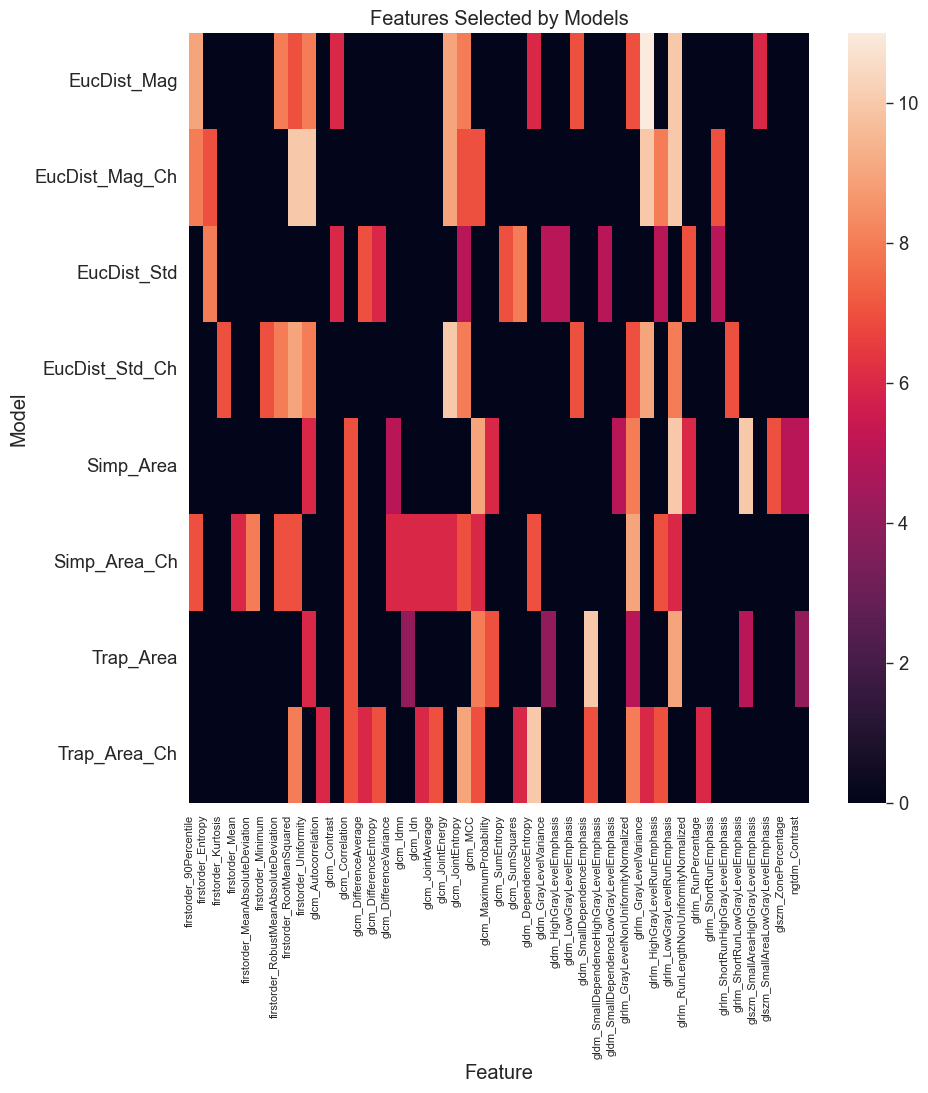

In [74]:
df_pivot = df_res.pivot("Model", "Feature", "Count")
df_pivot = df_pivot.fillna(0)

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df_pivot, annot=False, fmt="g", ax=ax)
ax.set_title("Features Selected by Models")
ax.set_ylabel("Model")
ax.set_xlabel("Feature")
# set index as y ticks
ax.set_xticks(np.arange(len(df_pivot.columns)))
ax.set_xticklabels(df_pivot.columns, rotation=90, ha="center", fontsize=8)
# if 0 dont label
#ax.set_yticklabels(df_pivot.columns, rotation=90, ha="right")
plt.show()
# save
#fig.savefig(, bbox_inches="tight")

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm


In [ ]:
####################################################

def DistanceMatrix(df, outdir, plot=False):
    '''
    Calculates the Euclidean distance between feature pair trajectories
    for each patient.
    Saves the distance matrix for each patient to a csv file.
    
    df: dataframe with all feature values across treatment for one region
    out_dir: output
    tag: tag for output to denote any changes
    output: print output
    plot: saves a heatmap of the distance matrix
    '''
    
    features = df["Feature"].unique()
    PatIDs = df["PatID"].unique()

    df_res = pd.DataFrame()

    print("Calculating Euclidean distance between feature pair trajectories...")

    if os.path.isdir(outdir + "/DM/") == False:
        os.mkdir(outdir + "/DM/")
        os.mkdir(outdir + "/DM/data/")
        os.mkdir(outdir + "/DM/figs/")
    
    for pat in tqdm(PatIDs):
        df_pat = df[df["PatID"] == pat]

        matrix = np.zeros((len(features), len(features)))

        for i, ft1 in enumerate(features):
            df_ft = df_pat[df_pat["Feature"] == ft1]
            vals1 = df_ft["FeatureValue"].values
            if vals1[0] == 0:
                vals1[0] = 1
            vals1_ch = (vals1 - vals1[0]) / vals1[0]
            for j, ft2 in enumerate(features):
                df_ft2 = df_pat[df_pat["Feature"] == ft2]
                vals2 = df_ft2["FeatureValue"].values
                if vals2[0] == 0:
                    vals2[0] = 1
                
                vals2_ch = (vals2 - vals2[0]) / vals2[0]
            
                # get euclidean distance
                # fill nan with 0
                if np.isnan(vals1_ch).any() == True:
                    print(pat)
                    print(ft1, vals1)
                if np.isnan(vals2_ch).any() == True:
                    print(pat)
                    print(ft2, vals2)
                
                diff = vals1_ch - vals2_ch

                matrix[i,j] = np.std(diff)
                # matrix[i,j] = distance.euclidean(vals1, vals2)
    
        df_dist = pd.DataFrame(matrix, columns=features, index=features)
        df_dist.to_csv(outdir + "/DM/data/" + str(pat) + ".csv")

        if plot == True:
            plt.figure(figsize=(10,10))
            sns.heatmap(df_dist, cmap="viridis")
            plt.title(str(pat), fontsize=20)
            # make sure all ticks show
            plt.xticks(np.arange(len(features)) + 0.5, features, fontsize=6)
            plt.yticks(np.arange(len(features)) + 0.5, features, fontsize=6)
            

            plt.savefig(outdir + "/DM/figs/" + str(pat) + ".png")
            plt.close()

Simp_Area
371116868.12773234
Median: 115.72634774466664
Mean: 12070449.878910854
Std: 60730105.91517901
10th P: 1.8127095546666665


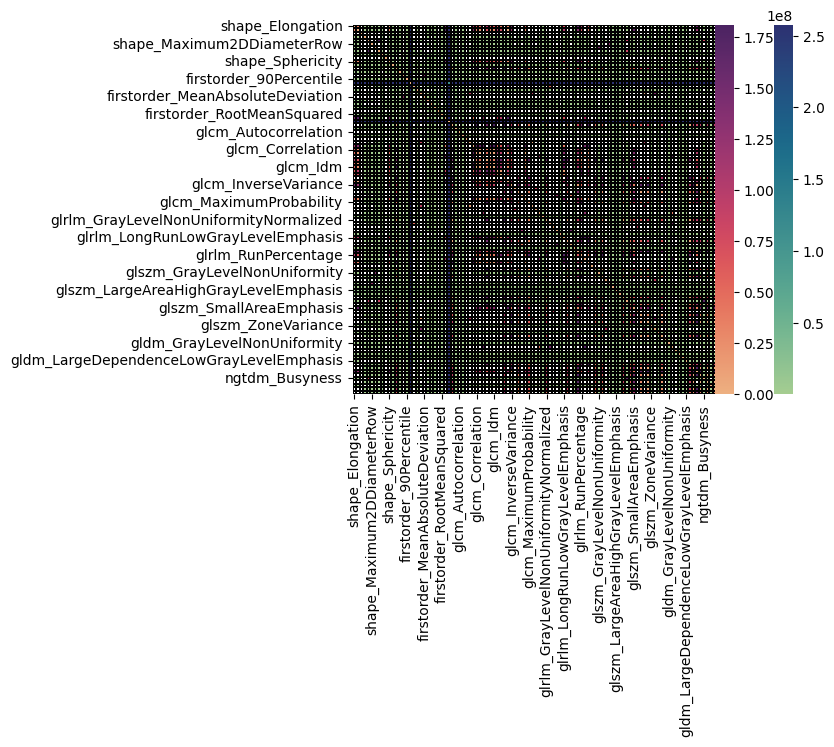

20th P: 6.5652052200666695


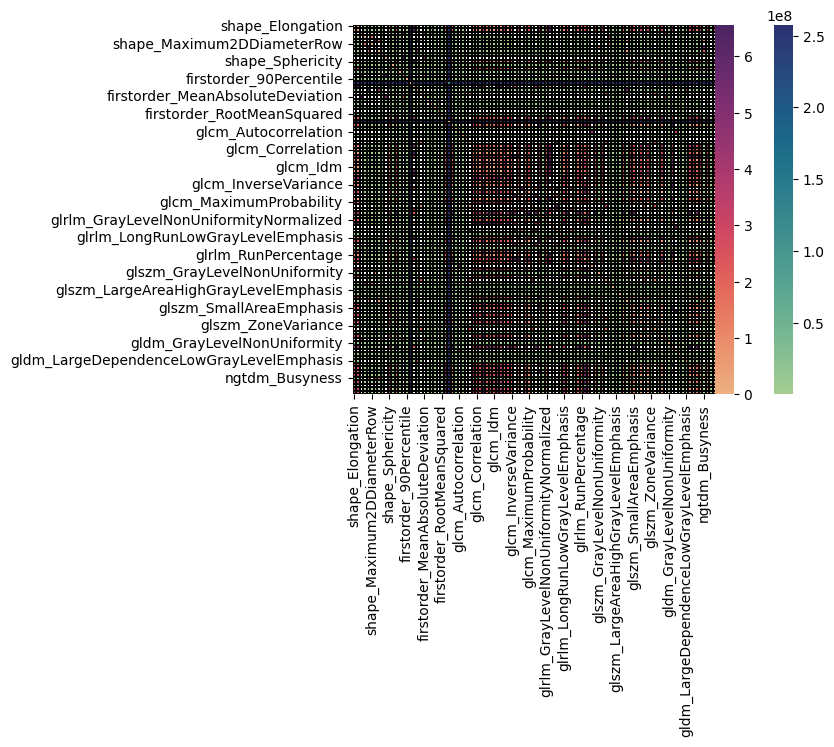

30th P: 22.887171792499995


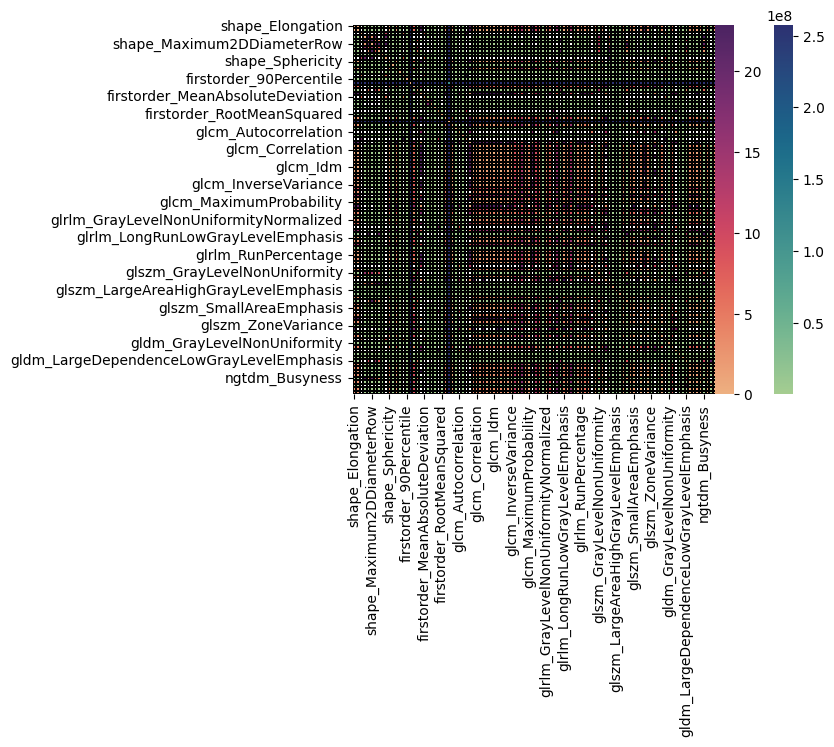

40th P: 58.5225765324001


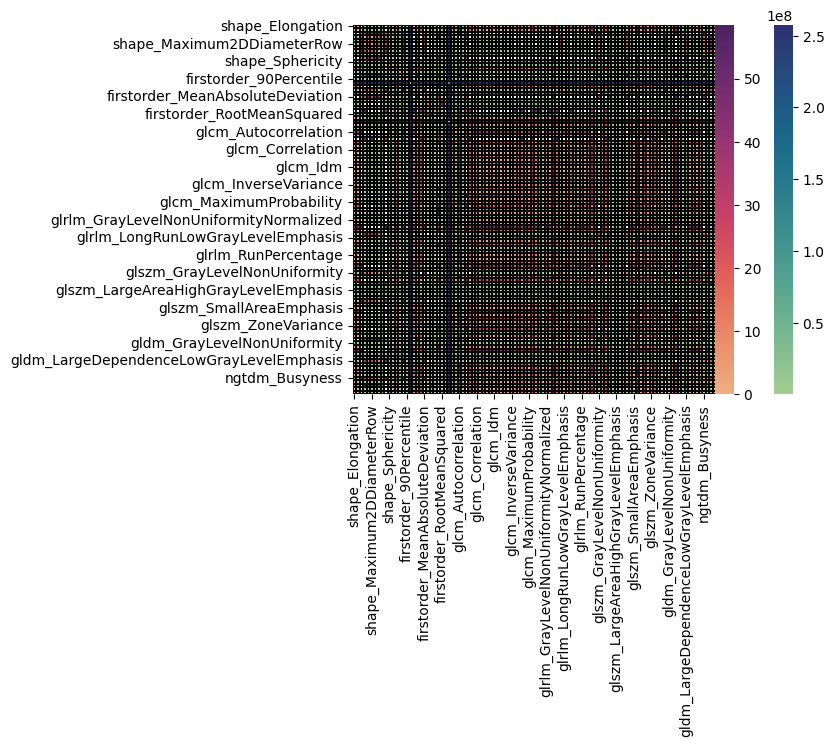

50th P: 115.72634774466664


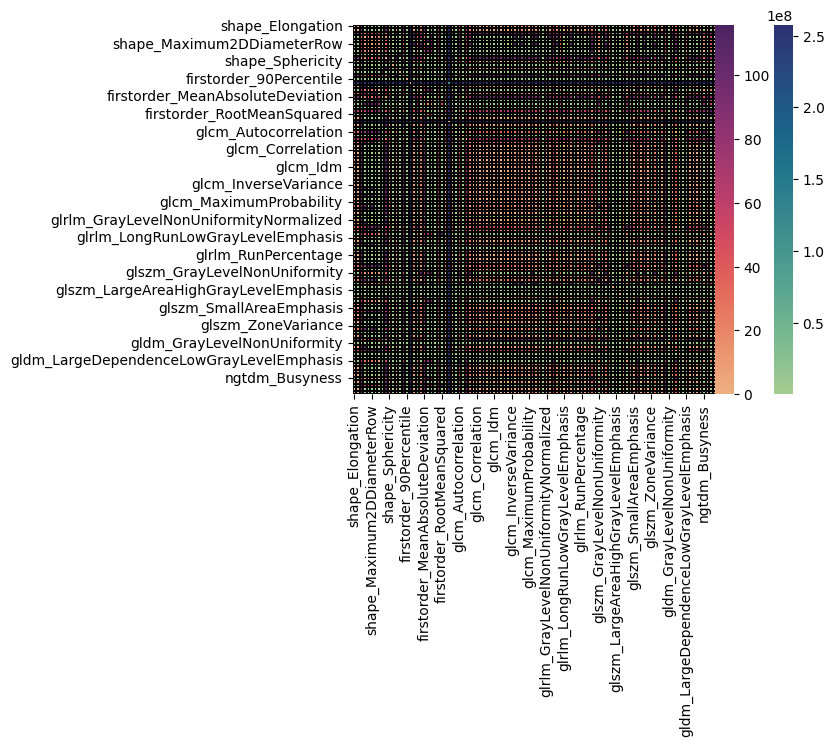

60th P: 148.57226880119995


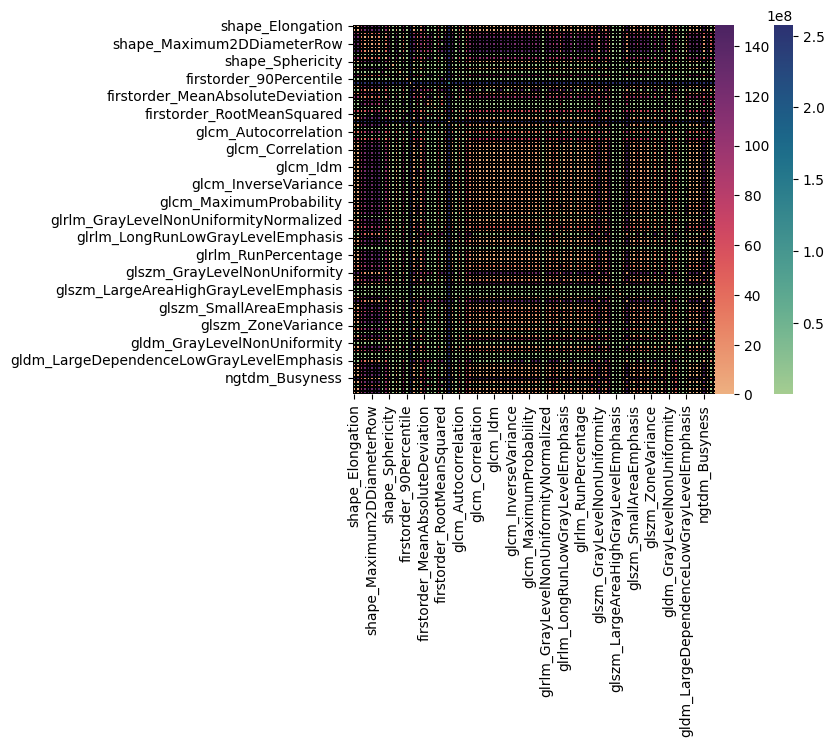

70th P: 647.0002788213334


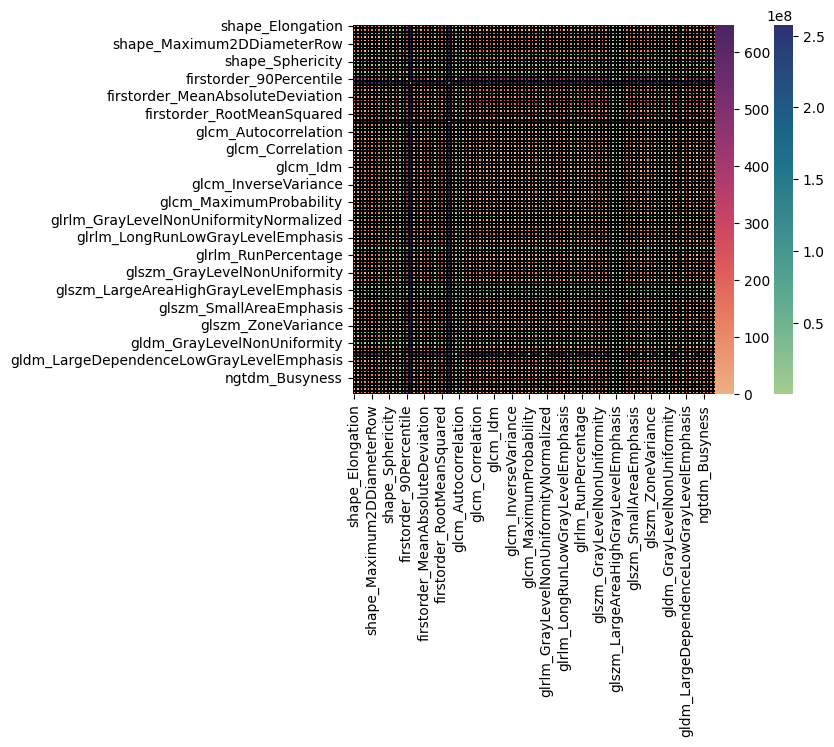

80th P: 9701.130474995334


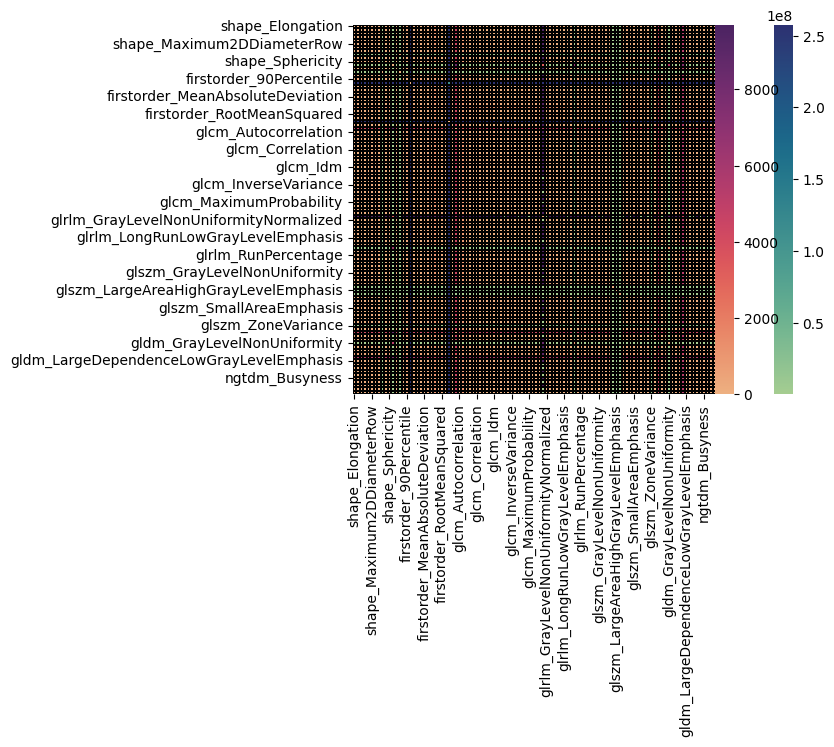

90th P: 226635.10544106428


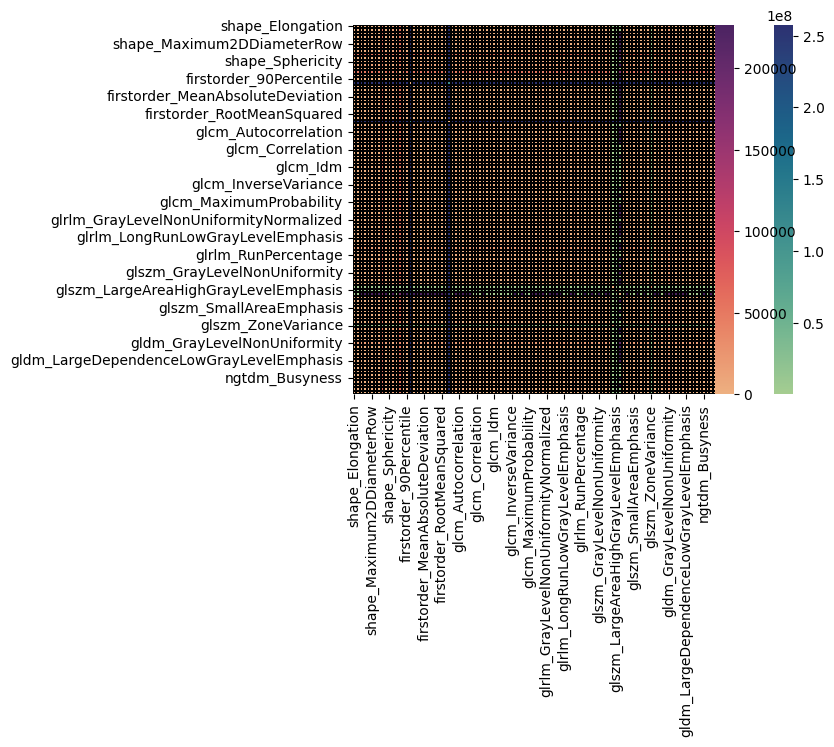

100th P: 371116868.12773234


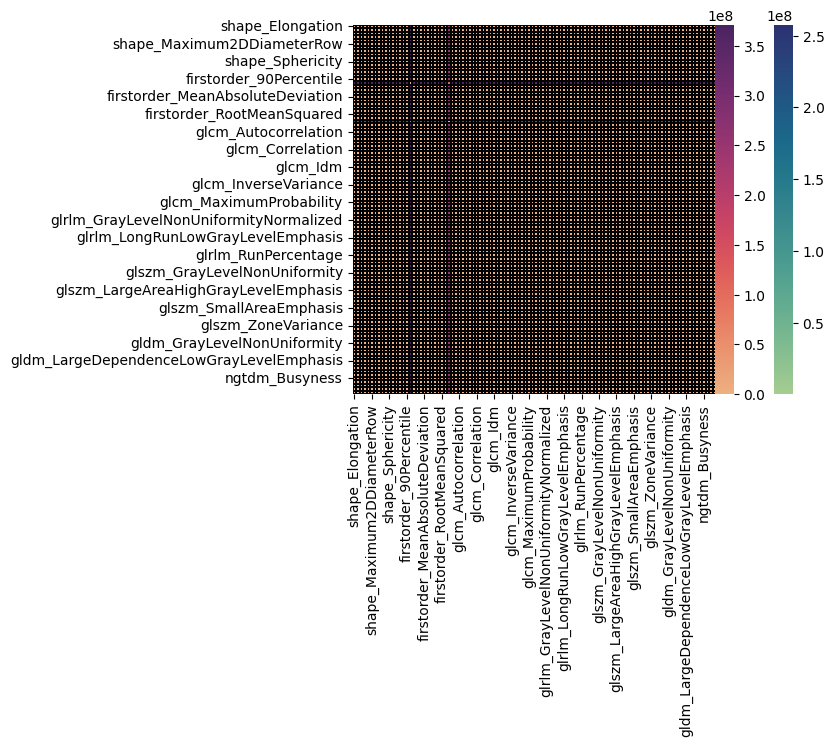

75971907.42010416
Median: 76.90376519683332
Mean: 2525967.1176112634
Std: 12425911.298093716
10th P: 1.4297307959


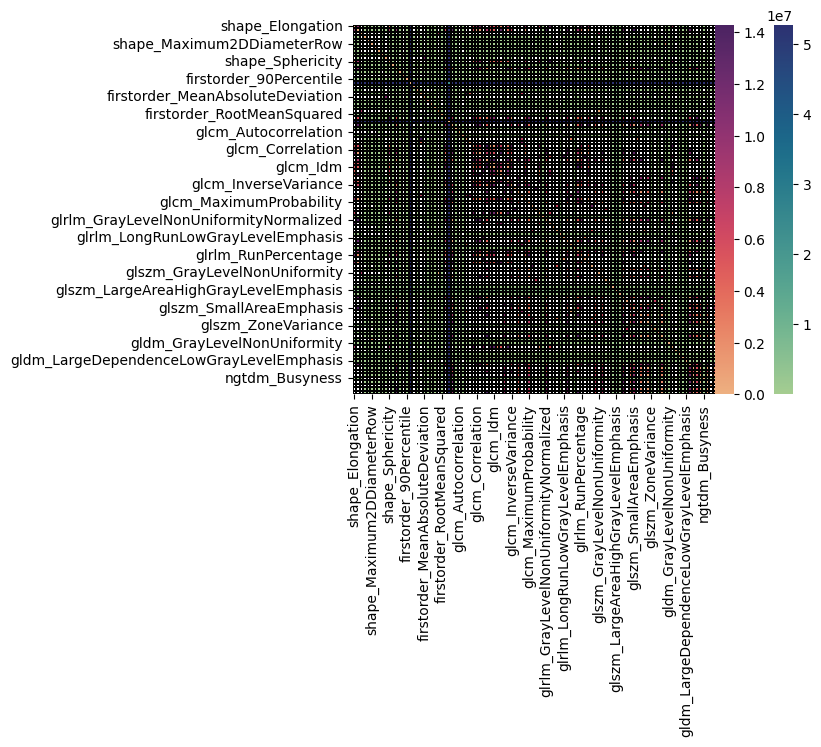

20th P: 4.831113299400005


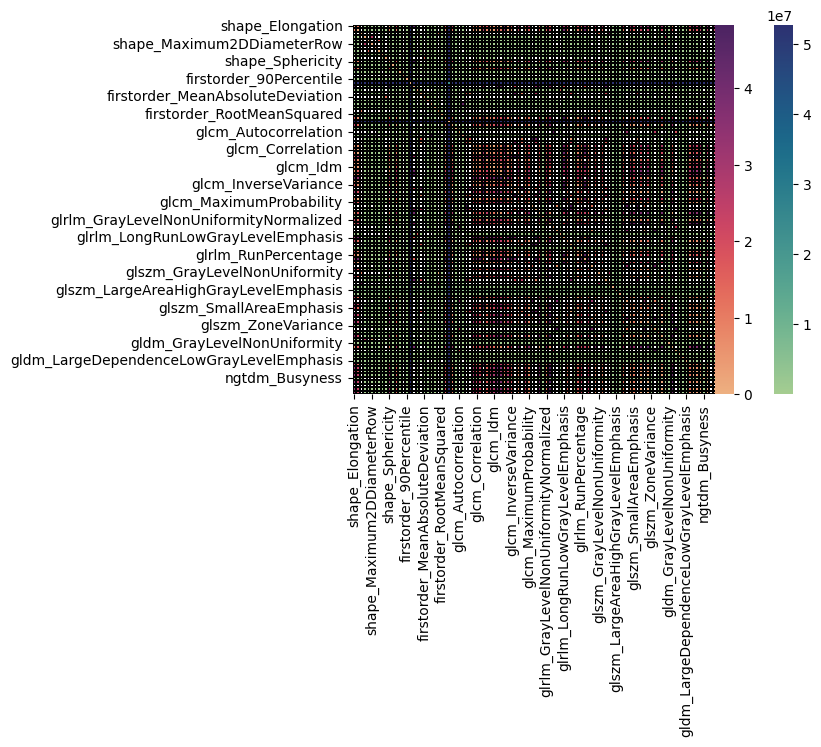

30th P: 14.092662794


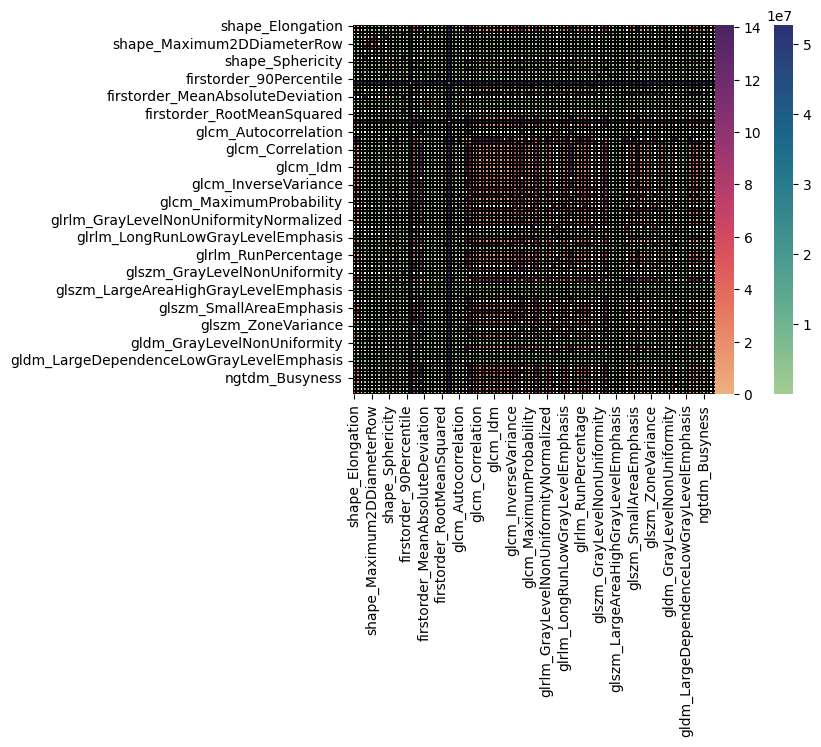

40th P: 30.426576949066675


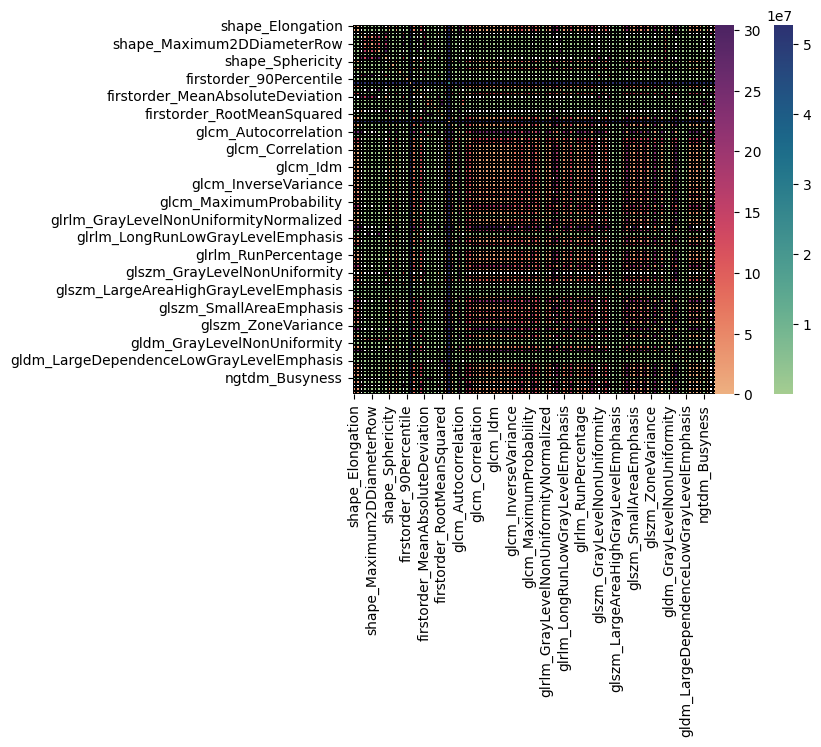

50th P: 76.90376519683332


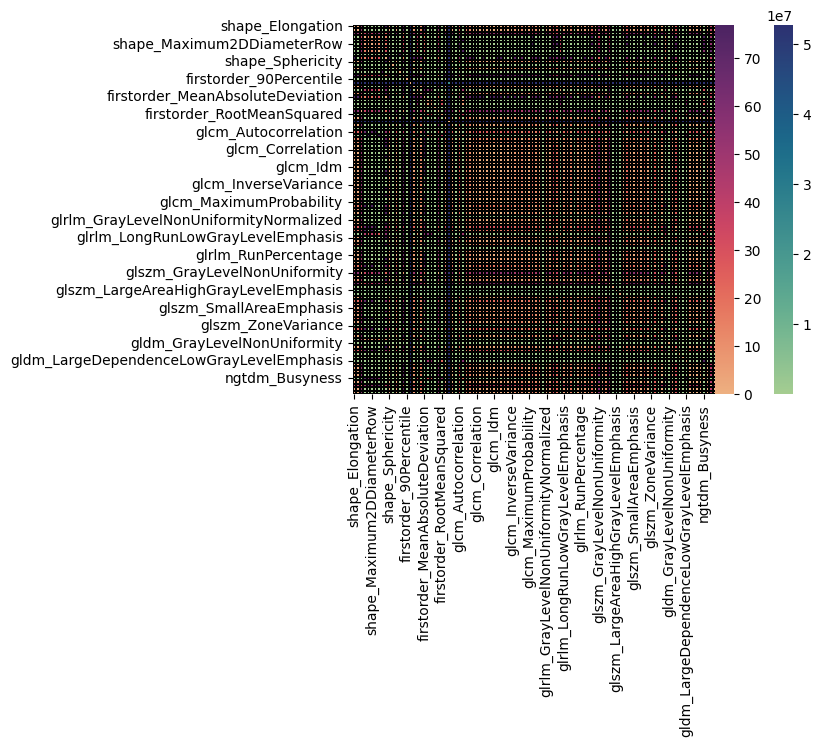

60th P: 131.96552066799998


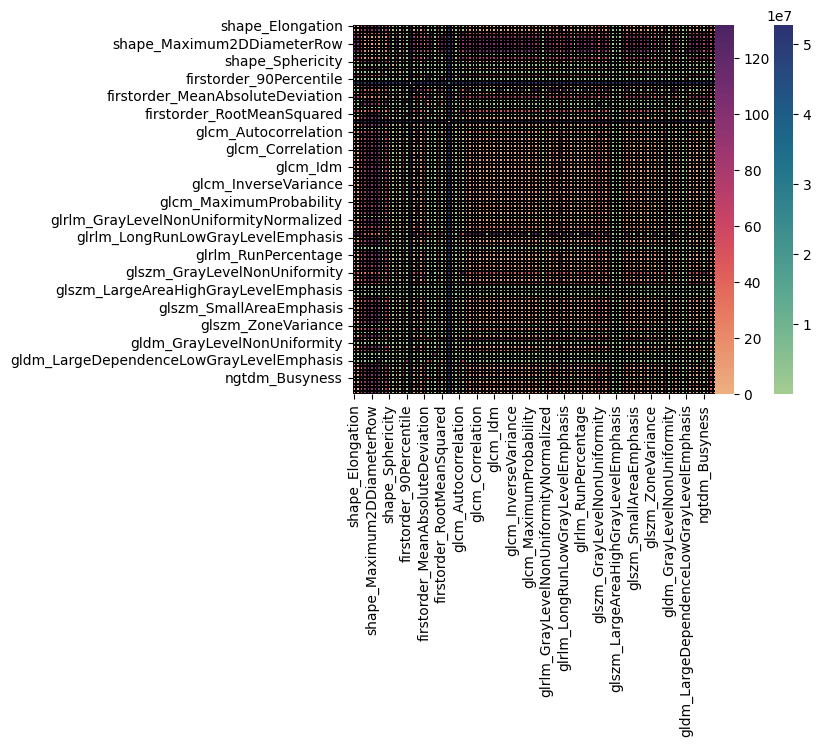

70th P: 321.5884789956666


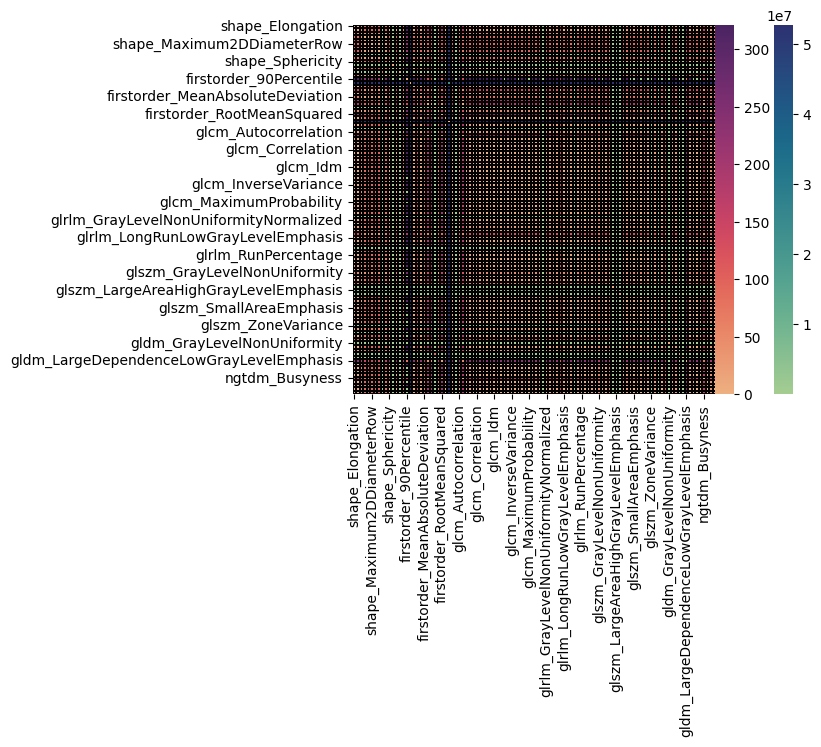

80th P: 4495.198127415332


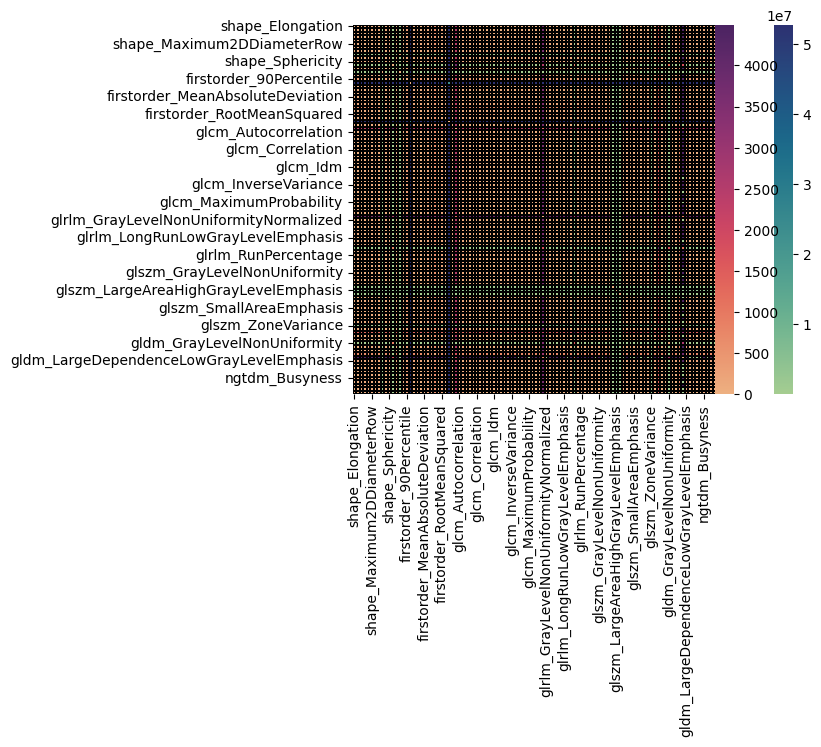

90th P: 170779.48339271778


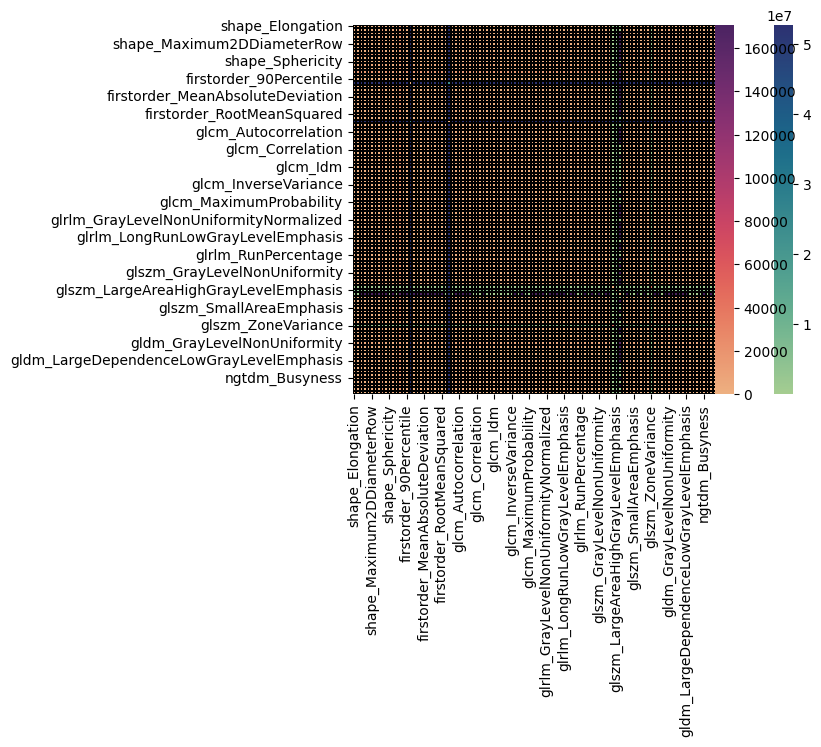

100th P: 75971907.42010416


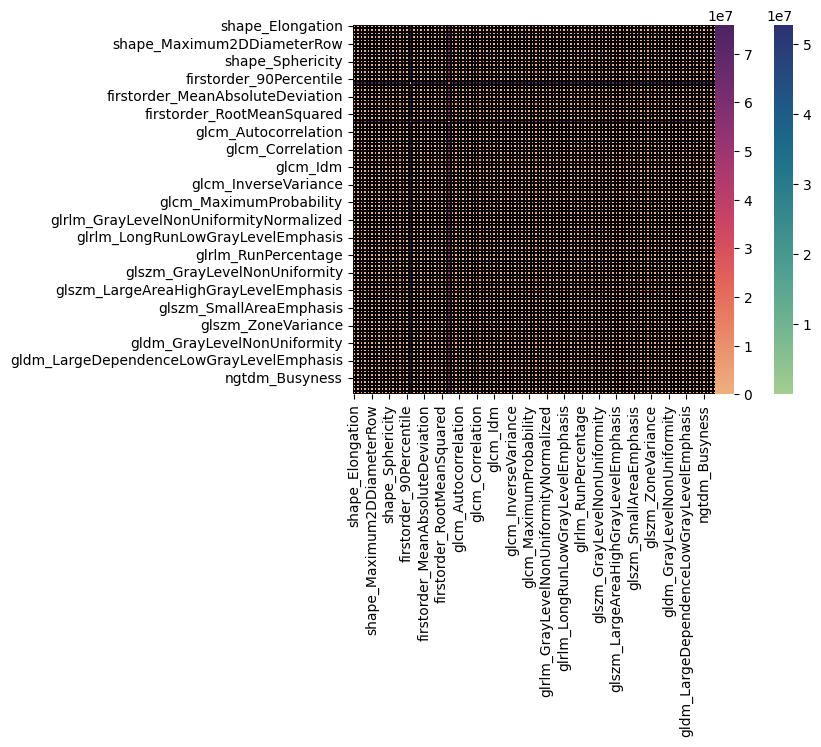

189197298.819664
Median: 96.33392429216667
Mean: 6170442.38168145
Std: 30956805.961955212
10th P: 1.795519333


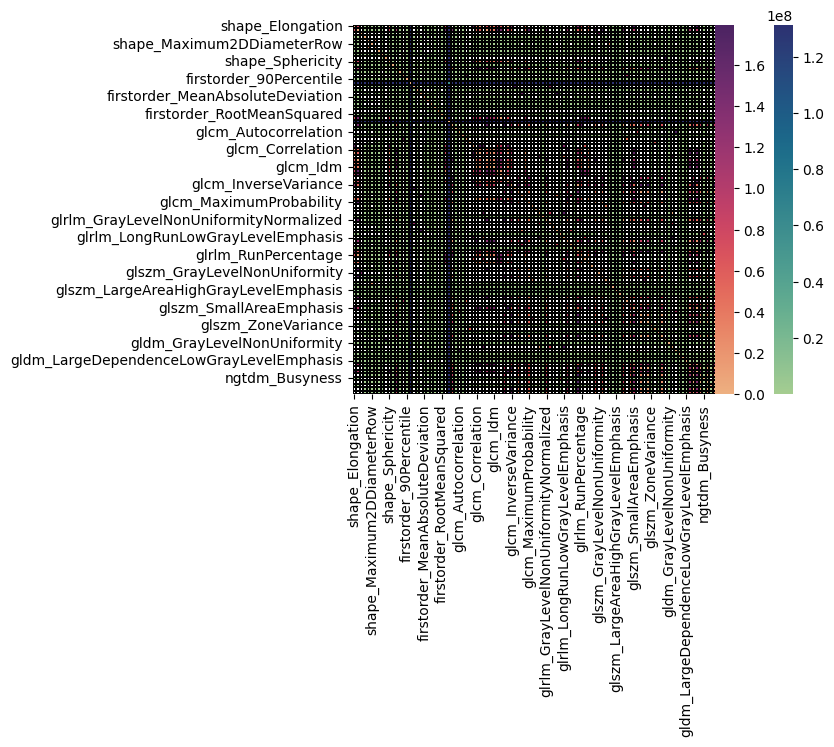

20th P: 6.419118349000008


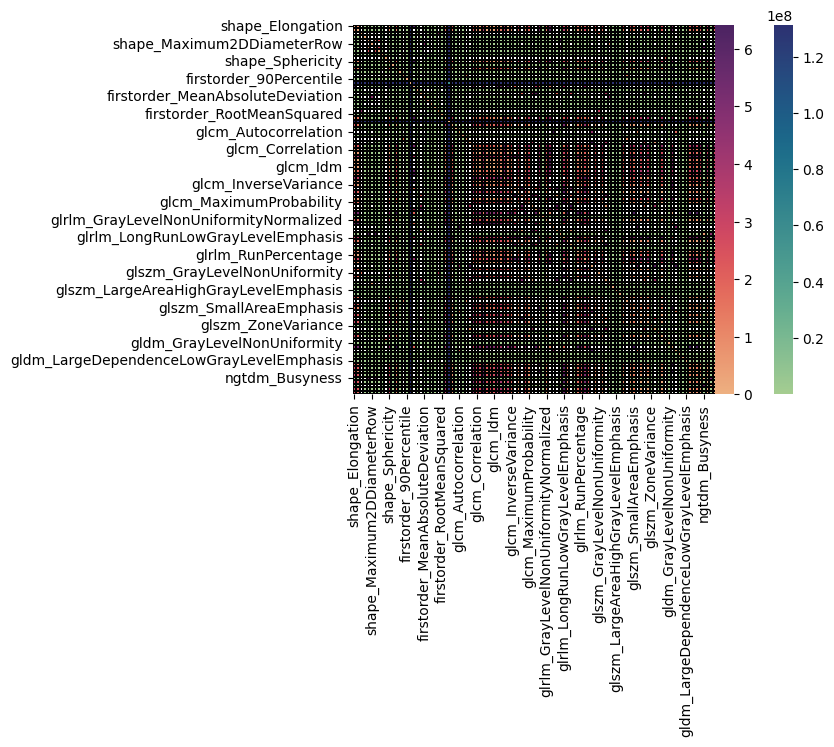

30th P: 20.67922108866666


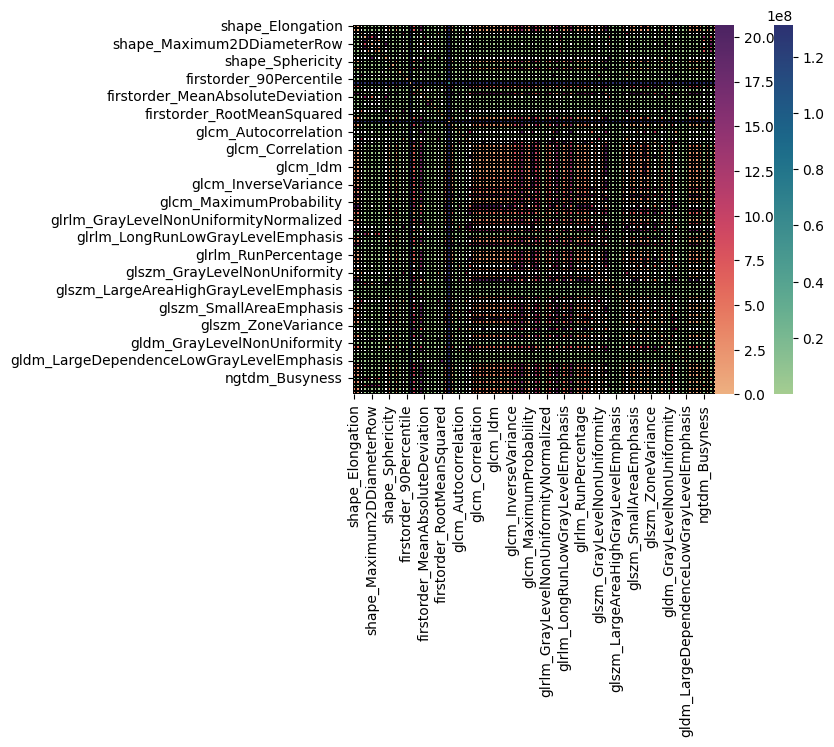

40th P: 51.22748088973339


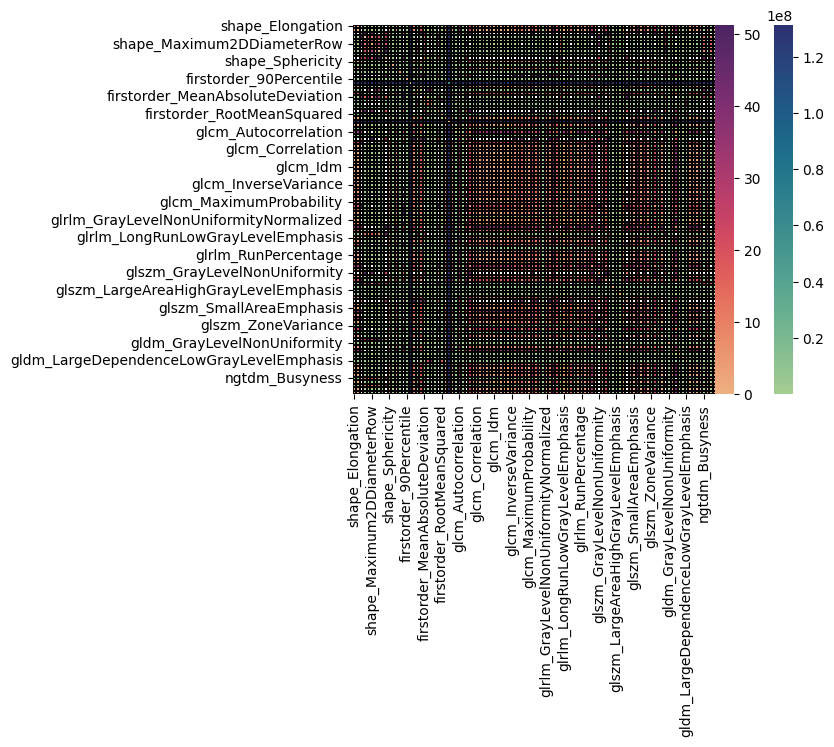

50th P: 96.33392429216667


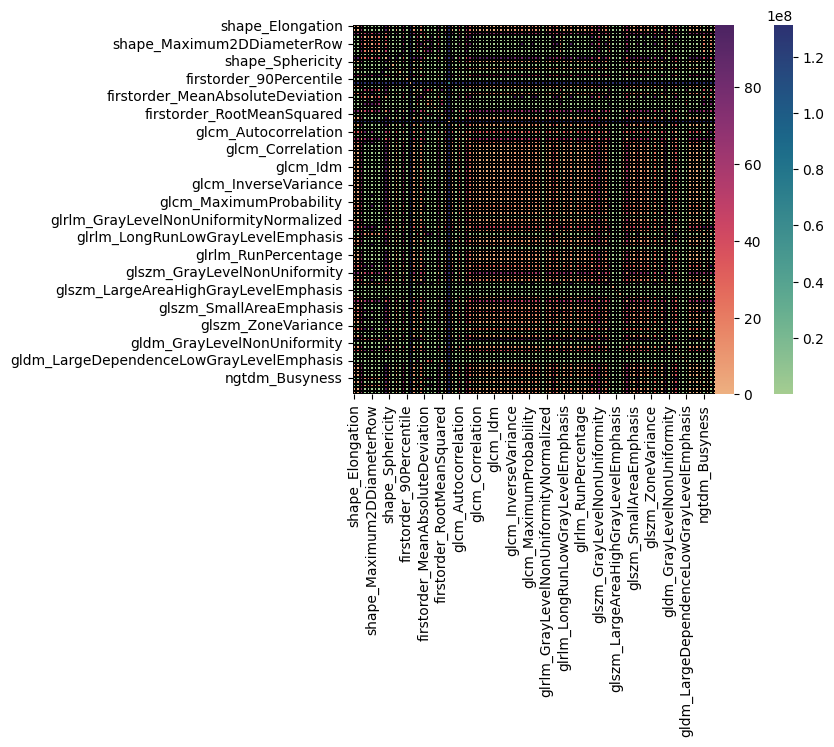

60th P: 137.75060859973334


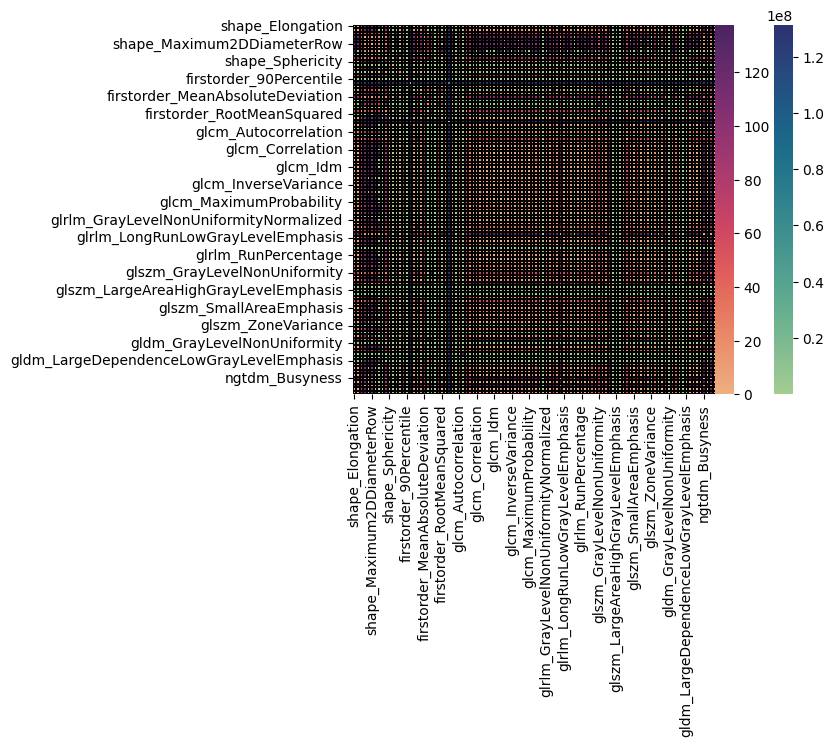

70th P: 607.1886833126666


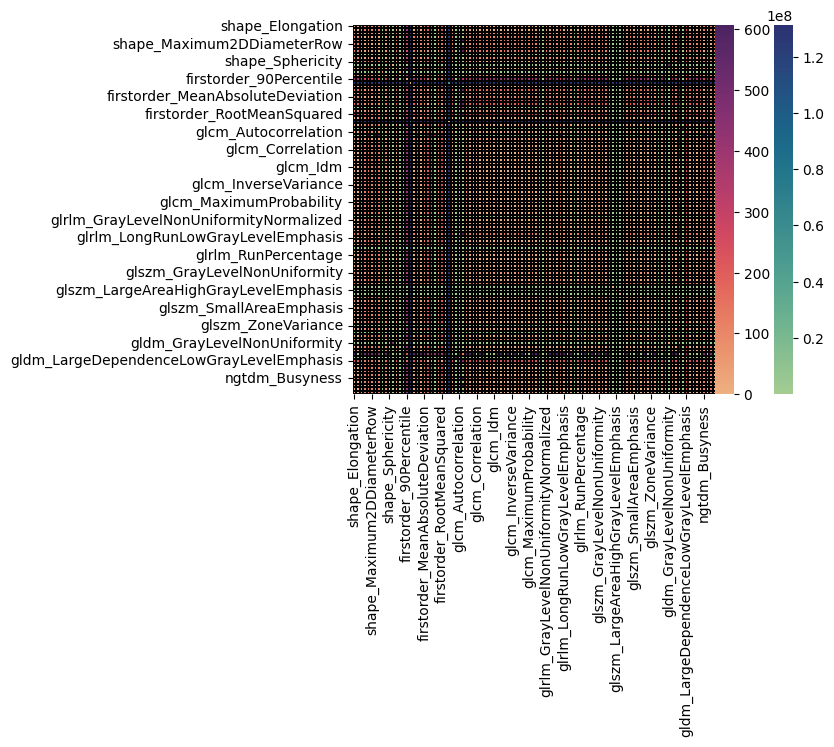

80th P: 5787.583685991


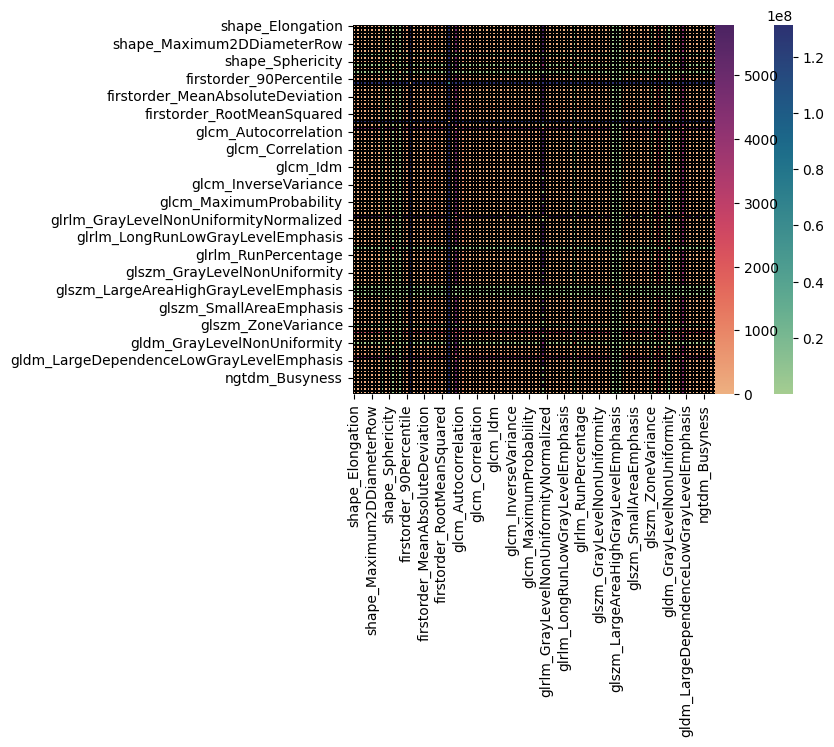

90th P: 258360.0272347491


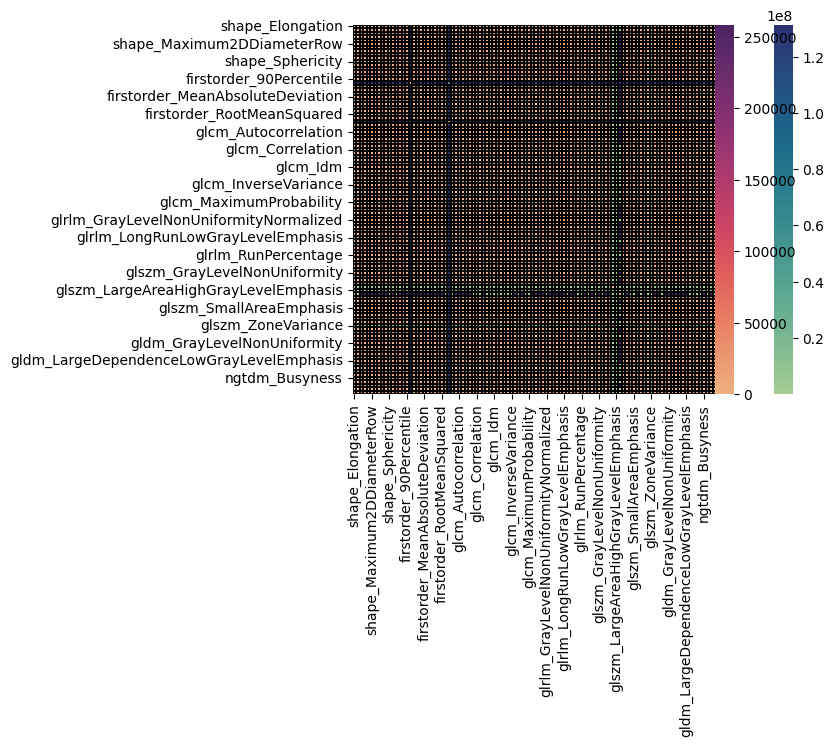

100th P: 189197298.819664


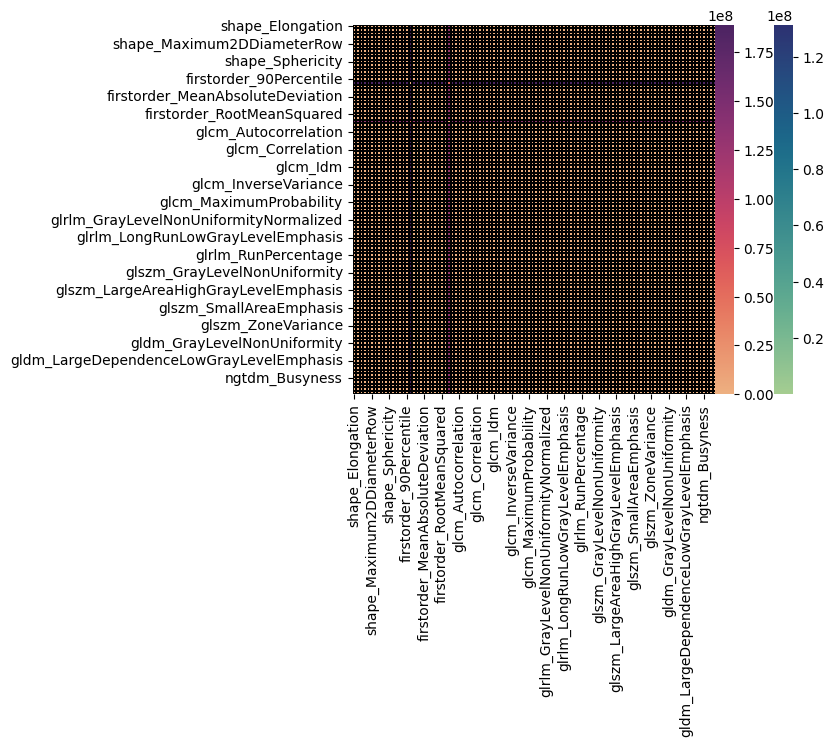

221434881.41201603
Median: 101.8985996335
Mean: 7439069.29673
Std: 36210406.894244045
10th P: 1.5295902041666674


KeyboardInterrupt: 

In [83]:
tags = []
output_dir = "C:\\Users\\b01297ar\\Documents\\ProstateMRL-local\\ProstateMRL-Radiomics\\Paper1-Release\\Output\\"

for tag in os.listdir(output_dir):
    if "_" in tag:
        if "Ch" not in tag:
            tags.append(tag)
def GenHM(df):

    max = 0
    features = df.columns
    df_h = df.copy()
    df_h.reset_index(inplace=True)
    df_h.rename(columns={'index':'Feature1'}, inplace=True)
    df_p = pd.melt(df_h, id_vars=['Feature1'], value_vars=df.columns[1:], var_name='Feature2', value_name='Measure')


    vals = df_p.Measure.values

    print(np.max(vals))
    if np.max(vals) > max:
        max = np.max(vals)
    print("Median: " + str(np.median(vals)))
    print("Mean: " + str(np.mean(vals)))
    print("Std: " + str(np.std(vals)))
    # print("10th P: " + str(np.percentile(vals, 10)))
    # print("50th P: " + str(np.percentile(vals, 50)))
    # print("75th P: " + str(np.percentile(vals, 75)))
    # print("90th P: " + str(np.percentile(vals, 90)))
    # print("95th P: " + str(np.percentile(vals, 95)))
    # print("99th P: " + str(np.percentile(vals, 99)))

    for i in range(10, 101, 10):
        print(str(i) + "th P: " + str(np.percentile(vals, i)))
    
        
        cmap1 = plt.get_cmap('crest').copy()
        cmap1.set_under('none')
        cmap2 = plt.get_cmap('flare').copy()
        cmap2.set_over('none')
        viscap = np.percentile(vals, i)
        ax1 = sns.heatmap(df, cmap=cmap1, vmin=np.median(vals), cbar_kws={"pad": -0.01}, robust=True)
        sns.heatmap(df, cmap=cmap2, vmin=0, vmax=viscap, ax=ax1, robust=True, cbar_kws={"pad": -0.01}, linecolor='black', linewidths=0.005)
        plt.show()
    #     vis_cap = np.percentile(vals, 60)
    #     plt.figure(figsize=(10,10))
    #     sns.heatmap(df, cmap="viridis", vmin=0, vmax=vis_cap)
    #     plt.title(str(pat), fontsize=20)
    #     # make sure all ticks show
    #     plt.xticks(np.arange(len(features)) + 0.5, features, fontsize=6)
    #     plt.yticks(np.arange(len(features)) + 0.5, features, fontsize=6)
        

    #     # plt.savefig(outdir + "/DM/figs/" + str(pat) + ".png")
    #     #plt.show()
    plt.close()

# tag = np.random.choice(tags, 1)[0#
tag = "Simp_Area"
print(tag)
# print tag index in list
# print(tags.index(tag))
path = "C:\\Users\\b01297ar\\Documents\\ProstateMRL-local\\ProstateMRL-Radiomics\\Paper1-Release\\Output\\" + tag + "\\DM\\data\\"

max = 0
for pat in os.listdir(path):
    if pat.endswith(".csv"):
        df = pd.read_csv(path + pat, index_col=0)
        GenHM(df)
        # pivot df to long

print("Max value: " + str(max))

In [8]:
low = np.tril(df_p)

<AxesSubplot:ylabel='Count'>

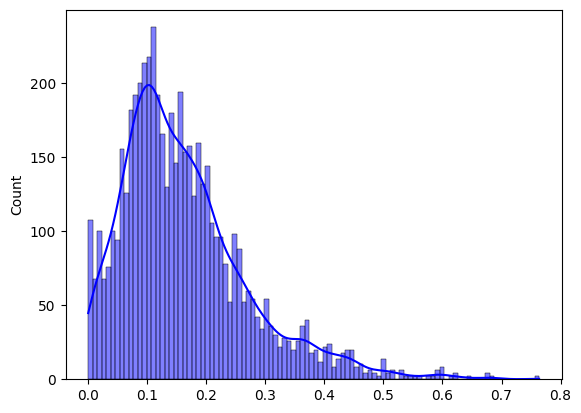

In [13]:
# plot histogram 
vals = df_p.Measure.values
sns.histplot(vals, bins=100, kde=True, color='blue', alpha=0.5)

In [ ]:

# plot histogram
fig = sns.histplot(data=df_p, x="Measure")